# First-Year Writing Seminars

**Objectives:**
* Assign students to FWS sections so that they get one of their top 5 choices.
* Improve assignments by making changes to our transportation formulation.

**Key Ideas:**
* integrality property
* the transportation problem
* the assignment problem

**Brief description:** If you recall pre-enroll, there was a separate ballot you completed by listing your top 5 picks for FWS that semester. You were later notified which class you got placed into, probably hoping it was your first choice. By now, this should not seem like magic; problems like these often enlist help from Operations Research especially as the scale increases. Disclaimer: the following model is not actually used by Cornell.

In [1]:
# imports -- make sure to run this cell
import pandas as pd
import math, itertools
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
from ortools.linear_solver import pywraplp as OR

## Part 1: Brainstorming

We want to *assign* a class to each student. This sounds like an assignment problem, which is a special case of the *transportation problem*. 

**Example 1**  
The following table gives an instance with 7 students (1-7) and 4 classes (A-D). Each class has a capacity of 2 students. 

| Student | First | Second |
|:-------:|:-----:|:------:|
|    1    |   A   |    B   |
|    2    |   D   |    C   |
|    3    |   A   |    C   |
|    4    |   B   |    D   |
|    5    |   C   |    B   |
|    6    |   A   |    B   |
|    7    |   B   |    A   |

**Q1:** What are the supply nodes?  

**A:** <font color='blue'>Students</font>  

**Q2:** What are the supply values of the supply nodes? (Hint: How many units can be transferred?)

**A:** <font color='blue'>1</font>  

**Q3:** What are the demand nodes?  

**A:** <font color='blue'>Classes</font>  

**Q4:** What are the demand values of the demand nodes? (Hint: How many units can be received?)

**A:** <font color='blue'> The capcity of the class the demand node represents. In this case, 2</font>  

**Q5:** What does a directed edge from a supply node to a demand node indicate?  

**A:** <font color='blue'>The student represented by the supply node could potentially be assigned to the class represented by the supply node.</font>

**Q6:** What are the edge costs?  

**A:** <font color='blue'> The edge cost from the student to their first choice is 1 and the edge cost from the student to their second choice is 2 since we want to minimize cost.</font>

**Q7:** Visualize your graph by completing the dictionary of edge costs. This will be used later as the input to the LP model.

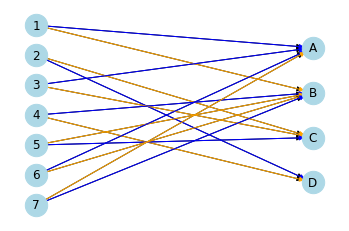

In [2]:
from fws_lab import ex1

S = [1,2,3,4,5,6,7]
D = ['A','B','C','D']
E = {(1,'A'):1, 
     (1,'B'):2, 
     (2,'D'):1, 
     (2,'C'):2, 
     (3,'A'):1, 
     (3,'C'):2, 
     (4,'B'):1, 
     (4,'D'):2, 
     (5,'C'):1, 
     (5,'B'):2, 
     (6,'A'):1, 
     (6,'B'):2, 
     (7,'B'):1, 
     (7,'A'):2 }

ex1(S, D, E)

To complete the simple model, we need to answer one more question.  

**Q8:** The total demand is 8, but the current total supply is only 7. How can we make sure that demand is satisfied for there to be a feasible solution?  

**A:** <font color='blue'>Add a dummy node and edges going from it to every class node with cost 3</font>  

**Q9:** Create a similar list of students, classes, and edge weights like the lists above but account for the dummy supply node.

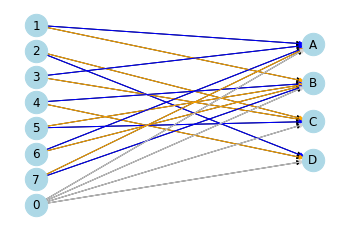

In [3]:
S_dummy = [1,2,3,4,5,6,7,0]
D_dummy = ['A','B','C','D']
E_dummy = {(1,'A'):1, (1,'B'):2, (2,'D'):1, (2,'C'):2, (3,'A'):1, (3,'C'):2, 
           (4,'B'):1, (4,'D'):2, (5,'C'):1, (5,'B'):2, (6,'A'):1, (6,'B'):2, 
           (7,'B'):1, (7,'A'):2, (0,'A'):3, (0,'B'):3, (0,'C'):3, (0,'D'):3}

ex1(S_dummy, D_dummy, E_dummy)

## Part 2: Solving

Let's use OR-Tools to define our mathematical model. 

**Q10:** Complete the constraints in the cell below.

In [4]:
# An FWS assignment model

# INPUTS:
# students: a list of students
# classes: a list of classes
# edges: a dictionary of edge costs
# csize: the class capacity 
# dcost: the cost of not assigning a student to one of their top 5 picks
def Assign(students, classes, edges, csize, dcost, solver):
    STUDENT = students + ['dummy']  # create student list add dummy node 
    CLASS = classes                 # create class list
    EDGES = list(edges.keys())      # create edge list
    
    newedges = list(itertools.product([0], CLASS))
    EDGES.extend(newedges)          # add dummy edges
    
    c = edges.copy()                # define c[i,j]
    for edge in newedges:
        c.update({edge : dcost})    # add c[i,dummy] costs
    
    # define model
    m = OR.Solver('assignFWS', solver)
    
    # decision variables
    x = {}    
    for i,j in EDGES:
        # define x(i,j) here
        x[i,j] = m.IntVar(0, m.infinity(), ('(%d, %s)' % (i,j))) 
        
    # define objective function here
    m.Minimize(sum(c[i,j]*x[i,j] for i,j in EDGES))
       
    # add constraint to ensure each student (not including the dummy) is assigned at most one class
    for k in students:
        if k != 'dummy':
            m.Add(sum(x[i,j] for i,j in EDGES if i==k) <= 1)
        
    # add constraint to ensure each class is full
    # ADD YOUR CODE HERE
        
    # SOLUTION 
    for k in CLASS:
        m.Add(sum(x[i,j] for i,j in EDGES if j==k) == csize)
    
    m.Solve()
    
    unmatched = []
    for k in STUDENT:
        if (sum(x[i,j].solution_value() for i,j in EDGES if i==k) == 0) and (k!='dummy'):
            unmatched.append(k)
    print("Unmatched students:", len(unmatched))
    
    matched = {}
    for i,j in EDGES:
        if x[i,j].solution_value() == 1:
            if c[i,j] in matched:
                matched[c[i,j]] += 1
            else:
                matched.update({c[i,j] : 1})
    if dcost in matched.keys():
        del matched[dcost]
    
    return matched

**Q11:** Replace `XXX` with the cost of the dummy edges and then run the cell.

In [5]:
sol1 = Assign(S, D, E, 2, 3, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
print(sol1)

Unmatched students: 0
{1: 6, 2: 1}


6 students got their first choice, 1 student got their second choice, and no students were left unmatched.   

**Q12:** Why can't all the students be assigned their first choice? Or do you think the answer you got could be better?  

**A:** <font color='blue'>Limited capacity of classes</font> 

**Example 2**  
In this new instance with 8 students (1-8) and 4 classes (A-D), more students prefer A and B than C and D:  

| Student | First | Second |
|:-------:|:-----:|:------:|
|    1    |   A   |    B   |
|    2    |   B   |    A   |
|    3    |   C   |    D   |
|    4    |   A   |    B   |
|    5    |   B   |    A   |
|    6    |   A   |    C   |
|    7    |   C   |    D   |
|    8    |   A   |    D   |

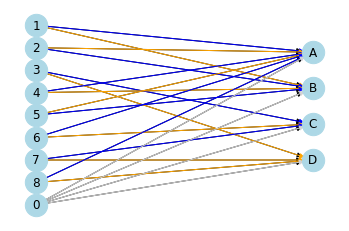

In [6]:
from fws_lab import ex2

S2 = [1,2,3,4,5,6,7,8]
D2 = ['A','B','C','D']
E2 = {(1,'A'):1, (1,'B'):2, (2,'B'):1, (2,'A'):2, (3,'C'):1, (3,'D'):2, (4,'A'):1, (4,'B'):2, 
      (5,'B'):1, (5,'A'):2, (6,'A'):1, (6,'C'):2, (7,'C'):1, (7,'D'):2, (8,'A'):1, (8,'D'):2}

ex2(S2, E2)

In [7]:
# cost of edges from dummy node is 2.5
sol2 = Assign(S2, D2, E2, 2, 2.5, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
print(sol2)

Unmatched students: 1
{1: 6, 2: 1}


There is 1 unmatched student when using 2.5 as the cost of dummy edges.  

**Q13:** Why can't all the students be assigned one of their top 2 choices? Or do you think the answer you got could be better?  

**A:** <font color='blue'>By adjusting the cost of an unmatched student, we can find an assignment in which all students are matched to a class.</font>  

Re-solve using 3.5 as the cost.

In [8]:
# cost of edges from dummy node is 3.5
sol3 = Assign(S2, D2, E2, 2, 3.5, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
print(sol3)

Unmatched students: 0
{1: 5, 2: 3}


**Q14:** Both the edge weights 2.5 and 3.5 are greater than 2. In some sense, they are prioritized last. We rather send flow across 1 and 2 weight edges. However, we get different solutions. Why?

**A:** <font color='blue'>The combined cost of a first pick edge and a dummy edge versus two second pick edges is  $1+2.5 < 2+2$ (edge cost 2.5) while is it $1+3.5 > 2+2$ (edge cost 3.5) </font>  

When solving the actual data, you will see that other subtle reasons might lead to unmatched students.

## Part 3: Solving the Actual Data

There are 2886 students and 183 class sections. Assume each class can have at most 16 students. As we already know, each student picks their top 5 classes.

In [10]:
# read in the dataset
data = pd.read_csv('data/f09_fws_ballots.csv')
data.head()    # preview

,STUDENTS,1,2,3,4,5
0,1,145,142,125,143,80
1,2,72,12,149,171,8
2,3,79,87,37,120,97
3,4,104,101,103,100,99
4,5,26,154,149,101,28


There are 6 columns with the first being student # and the other 5 being first, second, third, fourth, and fifth choice. Each row is a student, and class # indicates the class picked as the choice belonging to the column.  

The dataset has been transformed behind the scenes from what you see above into the correct formats for the inputs. Nothing has changed about the model except the edge costs are equal to the choice rank (1-5) and the edges from the dummy node have a cost of 6.

In [11]:
from fws_lab import inputData
students, classes, edges = inputData('data/f09_fws_ballots.csv')
data_sol = Assign(students, classes, edges, 16, 6, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
print(data_sol)

Unmatched students: 107
{1: 1658, 4: 138, 2: 621, 3: 328, 5: 34}


We got an answer! Unfortunately, there are 107 students who did not get any of their top 5 picks. Let's try to make our model better, so that no students are unmatched.  

The objective function is actually a weighted function. The coefficients, which in this case are the costs, dictate how much you want the solver to select the corresponding edges. An edge with a small cost has a higher likelihood (weight) of being in the solution while an edge with a large cost will potentially be avoided. This being said, we can try setting the cost of edges from the dummy node to an arbitrarily large number like 100,000. This should create greater incentive to fill classes with actual students than our fake filler 'students' as we witnessed in the second small example.

In [12]:
data_sol2 = Assign(students, classes, edges, 16, 100000, OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
print(data_sol2)

Unmatched students: 0
{1: 1532, 4: 208, 2: 673, 3: 384, 5: 89}


Yay! We just improved our model. As a bonus, we can look at the distribution of preferences received by students in the form of a histogram and see how our solution did in percentages.

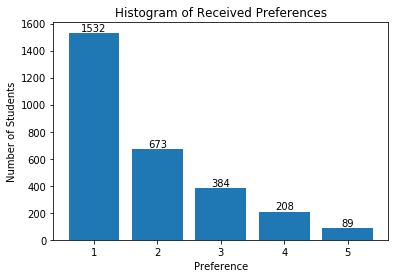

1 : 53.08 %
2 : 23.32 %
3 : 13.31 %
4 : 7.21 %
5 : 3.08 %


In [13]:
from fws_lab import Histo
Histo(data_sol2, 15)

for pref in range(1,6):
    print(pref, ":", round(100*data_sol2[pref]/2886, 2), "%")

## Bonus 1

We do not want to waste time trying different cost combinations if there is no solution where every student gets one of their top 5 picks. How can we check whether there exists a feasible solution with 0 unmatched students?  

**B1:** What is the cost of edges representing students' preferences?  

**A:** <font color='blue'>0</font>  

**B2:** What is the cost of dummy edges?  
    
**A:** <font color='blue'>1</font>  

**B3:** What is the desired solution?  

**A:** <font color='blue'>Zero cost assignment</font>  

**B4:** Describe another way that might use a different model.  

**A:** <font color='blue'>e.g. max flow</font>  

## Bonus 2

There are many ways to improve a model even if the type of problem does not change. Previously, we decided it was important for an assignment to guarantee that everyone got at least one of their top 5 picks. How can you make a better yet model? 

Your answer will depend on what you think makes the best assignment. Some things to consider: reducing the number of students getting their lesser-preferred choices, adding a lower bound on class size, choosing for two students to both have their 3rd choice instead of one 1st and the other 5th, using recursion...